/Users/sanskarparab/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Swin Transformer model loaded successfully on: cpu
Found 4616 total test images.


/Users/sanskarparab/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


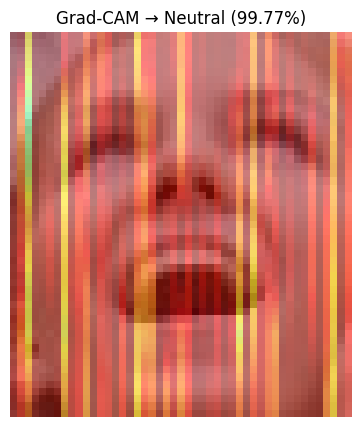

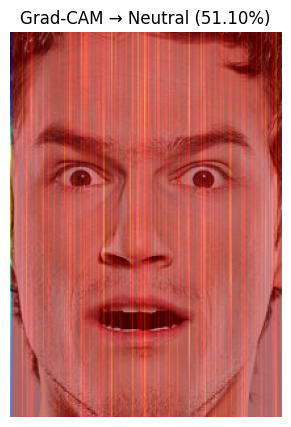

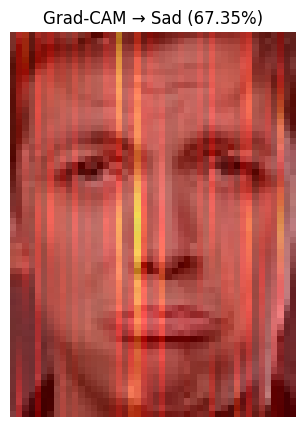

In [7]:
# =====================================
# 1️⃣ Imports
# =====================================
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
import timm

# =====================================
# 2️⃣ Define Custom Swin Transformer
# =====================================
class CustomSwinTransformer(nn.Module):
    def __init__(self, pretrained=False, num_classes=7):
        super(CustomSwinTransformer, self).__init__()
        self.backbone = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=pretrained,
            num_classes=0
        )
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

# =====================================
# 3️⃣ Load Trained Model
# =====================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/Users/sanskarparab/CC Emotion Detection /Facial-Expression-Recognition-FER-for-Mental-Health-Detection-/Models/Swin_FANE_Best_Model.pth"

model = CustomSwinTransformer(pretrained=False, num_classes=7)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print("✅ Swin Transformer model loaded successfully on:", DEVICE)

# =====================================
# 4️⃣ Test Images Setup
# =====================================
TEST_DIR = "/Users/sanskarparab/CC Emotion Detection /Facial-Expression-Recognition-FER-for-Mental-Health-Detection-/traintestsplit/test"
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Collect all image paths
image_paths = []
for emotion in emotions:
    folder = os.path.join(TEST_DIR, emotion)
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(folder, img_file))

print(f"Found {len(image_paths)} total test images.")

# =====================================
# 5️⃣ Define Image Transformations
# =====================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =====================================
# 6️⃣ Define Grad-CAM Class
# =====================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        target = output[0, class_idx]
        target.backward()
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.cpu().numpy()

# =====================================
# 7️⃣ Generate Grad-CAM on Random Images
# =====================================
# Pick 3 random test images
sample_imgs = random.sample(image_paths, 3)

# Choose a Swin Transformer feature layer
target_layer = model.backbone.layers[-1].blocks[-1].norm1
grad_cam = GradCAM(model, target_layer)

for img_path in sample_imgs:
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # Generate Grad-CAM heatmap
    cam_map = grad_cam.generate(img_tensor)
    cam_map = cv2.resize(cam_map, (img.size[0], img.size[1]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Overlay Grad-CAM on image
    overlay = heatmap + np.float32(img) / 255
    overlay = overlay / np.max(overlay)

    # Prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0].cpu().numpy()
    pred_idx = np.argmax(probs)
    pred_emotion = emotions[pred_idx]
    confidence = probs[pred_idx] * 100

    # Show result
    plt.figure(figsize=(5, 5))
    plt.imshow(overlay)
    plt.title(f"Grad-CAM → {pred_emotion} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

✅ Swin Transformer model loaded successfully on: cpu
Found 4616 total test images.


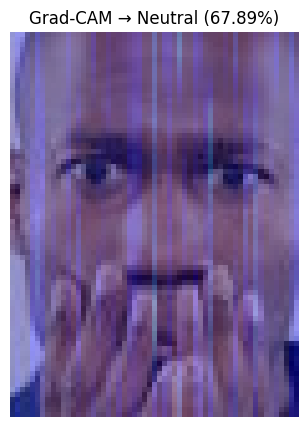

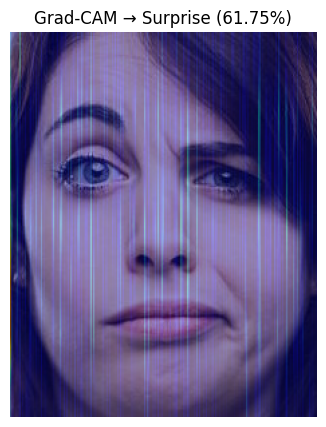

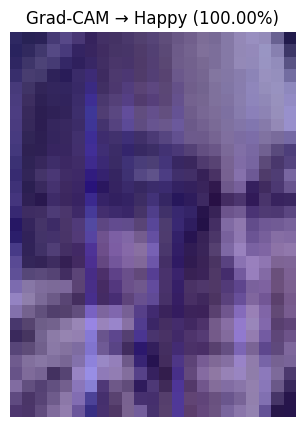

In [8]:
# =====================================
# 1️⃣ Imports
# =====================================
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
import timm

# =====================================
# 2️⃣ Define Custom Swin Transformer
# =====================================
class CustomSwinTransformer(nn.Module):
    def __init__(self, pretrained=False, num_classes=7):
        super(CustomSwinTransformer, self).__init__()
        self.backbone = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=pretrained,
            num_classes=0
        )
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

# =====================================
# 3️⃣ Load Trained Model
# =====================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/Users/sanskarparab/CC Emotion Detection /Facial-Expression-Recognition-FER-for-Mental-Health-Detection-/Models/Swin_FANE_Best_Model.pth"

model = CustomSwinTransformer(pretrained=False, num_classes=7)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print("✅ Swin Transformer model loaded successfully on:", DEVICE)

# =====================================
# 4️⃣ Test Images Setup
# =====================================
TEST_DIR = "/Users/sanskarparab/CC Emotion Detection /Facial-Expression-Recognition-FER-for-Mental-Health-Detection-/traintestsplit/test"
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Collect all image paths
image_paths = []
for emotion in emotions:
    folder = os.path.join(TEST_DIR, emotion)
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(folder, img_file))

print(f"Found {len(image_paths)} total test images.")

# =====================================
# 5️⃣ Define Image Transformations
# =====================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =====================================
# 6️⃣ Define Grad-CAM Class (Improved)
# =====================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        # use full backward hook (no deprecation warning)
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        target = output[0, class_idx]
        target.backward()

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.cpu().numpy()

# =====================================
# 7️⃣ Generate Grad-CAM on Random Images
# =====================================
# Pick 3 random test images
sample_imgs = random.sample(image_paths, 3)

# Choose a Swin Transformer feature layer
target_layer = model.backbone.layers[-1].blocks[-1].norm1
grad_cam = GradCAM(model, target_layer)

for img_path in sample_imgs:
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # Generate Grad-CAM heatmap
    cam_map = grad_cam.generate(img_tensor)
    cam_map = cv2.resize(cam_map, (img.size[0], img.size[1]), interpolation=cv2.INTER_LINEAR)

    # Create a smoother heatmap overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    img_np = np.array(img)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0].cpu().numpy()
    pred_idx = np.argmax(probs)
    pred_emotion = emotions[pred_idx]
    confidence = probs[pred_idx] * 100

    # Show result
    plt.figure(figsize=(5, 5))
    plt.imshow(overlay)
    plt.title(f"Grad-CAM → {pred_emotion} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

✅ Swin Transformer model loaded successfully on: cpu
Found 4616 total test images.


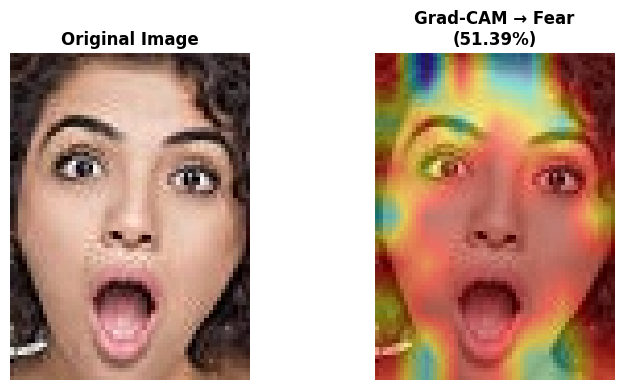

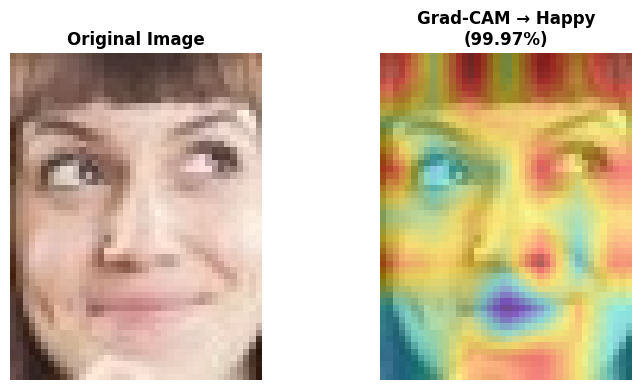

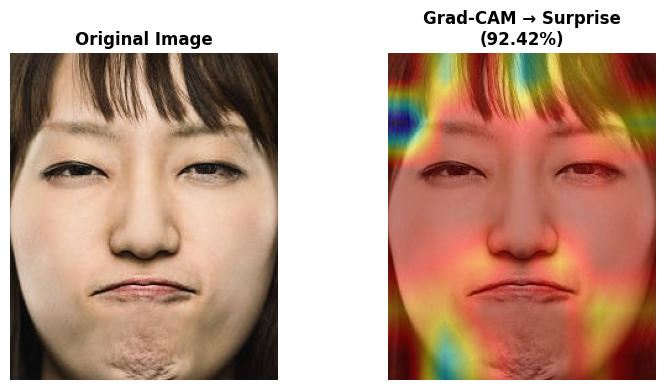

In [9]:
# =====================================
# 1️⃣ Imports
# =====================================
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
import timm

# =====================================
# 2️⃣ Define Custom Swin Transformer
# =====================================
class CustomSwinTransformer(nn.Module):
    def __init__(self, pretrained=False, num_classes=7):
        super(CustomSwinTransformer, self).__init__()
        self.backbone = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=pretrained,
            num_classes=0
        )
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

# =====================================
# 3️⃣ Load Trained Model
# =====================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/Users/sanskarparab/CC Emotion Detection /Facial-Expression-Recognition-FER-for-Mental-Health-Detection-/Models/Swin_FANE_Best_Model.pth"

model = CustomSwinTransformer(pretrained=False, num_classes=7)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print("✅ Swin Transformer model loaded successfully on:", DEVICE)

# =====================================
# 4️⃣ Test Images Setup
# =====================================
TEST_DIR = "/Users/sanskarparab/CC Emotion Detection /Facial-Expression-Recognition-FER-for-Mental-Health-Detection-/traintestsplit/test"
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Collect all image paths
image_paths = []
for emotion in emotions:
    folder = os.path.join(TEST_DIR, emotion)
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(folder, img_file))

print(f"Found {len(image_paths)} total test images.")

# =====================================
# 5️⃣ Define Image Transformations
# =====================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =====================================
# 6️⃣ Corrected Grad-CAM for Swin Transformer
# =====================================
class SwinGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()  # [B, N, C]
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        target = output[0, class_idx]
        target.backward()

        weights = torch.mean(self.gradients, dim=1, keepdim=True)
        cam = torch.sum(weights * self.activations, dim=-1)  # [B, N]
        cam = torch.relu(cam)

        # Reshape tokens to spatial grid
        size = int(cam.shape[1] ** 0.5)
        cam = cam.reshape(size, size).cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# =====================================
# 7️⃣ Generate Grad-CAM Visualizations
# =====================================
# Pick 3 random test images
sample_imgs = random.sample(image_paths, 3)

# Choose a deep Swin Transformer layer
target_layer = model.backbone.layers[-1].blocks[-1].norm2
grad_cam = SwinGradCAM(model, target_layer)

for img_path in sample_imgs:
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # Generate Grad-CAM heatmap
    cam_map = grad_cam.generate(img_tensor)
    cam_map = cv2.resize(cam_map, (img.size[0], img.size[1]))

    # Apply colormap and overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    img_np = np.float32(img) / 255
    overlay = 0.4 * heatmap + 0.6 * img_np
    overlay = overlay / np.max(overlay)

    # Get prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0].cpu().numpy()
    pred_idx = np.argmax(probs)
    pred_emotion = emotions[pred_idx]
    confidence = probs[pred_idx] * 100

    # Display: original + Grad-CAM side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img_np)
    axs[0].set_title("Original Image", fontsize=12, fontweight='bold')
    axs[0].axis('off')

    axs[1].imshow(overlay)
    axs[1].set_title(f"Grad-CAM → {pred_emotion}\n({confidence:.2f}%)", fontsize=12, fontweight='bold')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

✅ Swin Transformer model loaded successfully on: cpu
Found 4616 total test images.


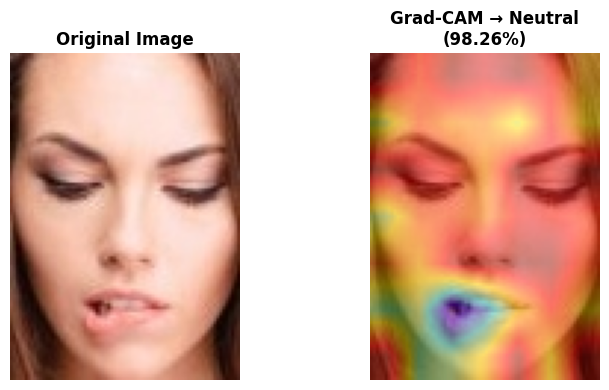

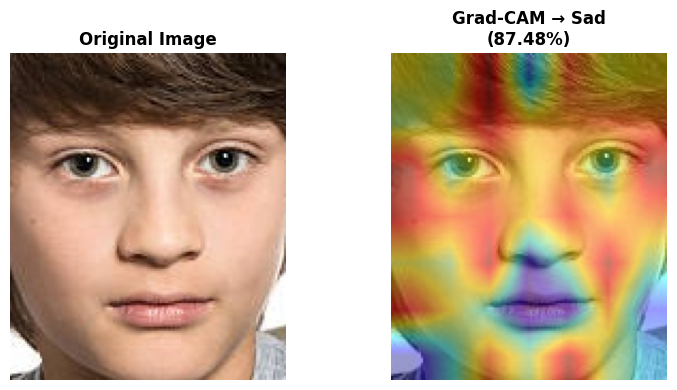

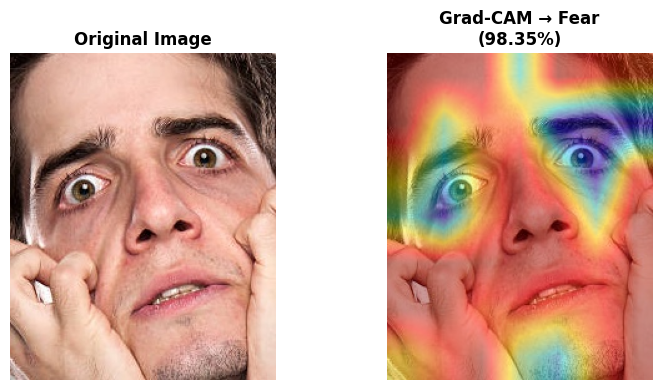

In [11]:
# =====================================
# 1️⃣ Imports
# =====================================
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
import timm

# =====================================
# 2️⃣ Define Custom Swin Transformer
# =====================================
class CustomSwinTransformer(nn.Module):
    def __init__(self, pretrained=False, num_classes=7):
        super(CustomSwinTransformer, self).__init__()
        self.backbone = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=pretrained,
            num_classes=0
        )
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

# =====================================
# 3️⃣ Load Trained Model
# =====================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/Users/sanskarparab/CC Emotion Detection /Facial-Expression-Recognition-FER-for-Mental-Health-Detection-/Models/Swin_FANE_Best_Model.pth"

model = CustomSwinTransformer(pretrained=False, num_classes=7)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print("✅ Swin Transformer model loaded successfully on:", DEVICE)

# =====================================
# 4️⃣ Test Images Setup
# =====================================
TEST_DIR = "/Users/sanskarparab/CC Emotion Detection /Facial-Expression-Recognition-FER-for-Mental-Health-Detection-/traintestsplit/test"
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Collect all image paths
image_paths = []
for emotion in emotions:
    folder = os.path.join(TEST_DIR, emotion)
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(folder, img_file))

print(f"Found {len(image_paths)} total test images.")

# =====================================
# 5️⃣ Define Image Transformations
# =====================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =====================================
# 6️⃣ Corrected Grad-CAM for Swin Transformer
# =====================================
class SwinGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()  # [B, N, C]
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        target = output[0, class_idx]
        target.backward()

        weights = torch.mean(self.gradients, dim=1, keepdim=True)
        cam = torch.sum(weights * self.activations, dim=-1)  # [B, N]
        cam = torch.relu(cam)

        # Reshape tokens to spatial grid
        size = int(cam.shape[1] ** 0.5)
        cam = cam.reshape(size, size).cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# =====================================
# 7️⃣ Generate Grad-CAM Visualizations
# =====================================
# Pick 3 random test images
sample_imgs = random.sample(image_paths, 3)

# Choose a deep Swin Transformer layer
target_layer = model.backbone.layers[-1].blocks[-1].norm2
grad_cam = SwinGradCAM(model, target_layer)

for img_path in sample_imgs:
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # Generate Grad-CAM heatmap
    cam_map = grad_cam.generate(img_tensor)
    cam_map = cv2.resize(cam_map, (img.size[0], img.size[1]))

    # Apply colormap and overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    img_np = np.float32(img) / 255
    overlay = 0.4 * heatmap + 0.6 * img_np
    overlay = overlay / np.max(overlay)

    # Get prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0].cpu().numpy()
    pred_idx = np.argmax(probs)
    pred_emotion = emotions[pred_idx]
    confidence = probs[pred_idx] * 100

    # Display: original + Grad-CAM side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img_np)
    axs[0].set_title("Original Image", fontsize=12, fontweight='bold')
    axs[0].axis('off')

    axs[1].imshow(overlay)
    axs[1].set_title(f"Grad-CAM → {pred_emotion}\n({confidence:.2f}%)", fontsize=12, fontweight='bold')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()